# ECE 57000 Assignment 4 Exercise

Your Name: Ti-Wei Chen

## Exercise 0: Train your model on GPU (0 points)

For some tasks in this assignment, it can take a long time if you run it on CPU. For example, based on our test on Exercise 3 Task 4, it will take roughly 2 hours to train the full model for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.



In [1]:
import torch
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [2]:
import torch.nn as nn
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

device = torch.device('cuda')
# Move rand_tensor and model onto the GPU device

simple_model = simple_model.to(device)
rand_tensor = rand_tensor.to(device)

print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


## Exercise 1: Why use a CNN rather than only fully connected layers? (30 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Following the structure used in the instructions, you should create

*   One network named **OurFC** which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network 
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named **OurCNN** which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions
* You are **required** to print out the loss in the training and loss+accuracy in the test as in the instructions.

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

"""
Here the transform is a pipeline containing two seperate transforms: 
1. Transform the data into tensor type
2. Normalize the dataset by a giving mean and std. 
  (Those number is given as the global mean and standard deviation of MNIST dataset)
"""
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,),(0.3081,))]
     )

train_dataset = torchvision.datasets.MNIST('/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('/data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

# (Batchsize x Channel x Height x Width)
batch_idx, (images, targets) = next(enumerate(train_loader))

def plot_visualize():
  print(f'current batch index is {batch_idx}')
  print(f'images has shape {images.size()}')
  print(f'targets has shape {targets.size()}')
  fig, ax = plt.subplots(3,3)
  fig.set_size_inches(12,12)

  for i in range(3):
    for j in range(3):
      ax[i,j].imshow(images[i*3+j][0], cmap='gray')
      ax[i,j].set_title(f'label {targets[i*3+j]}')
  fig.show()

def train(classifier, epoch):

  classifier.train() # we need to set the mode for our model

  for batch_idx, (images, targets) in enumerate(train_loader):

    optimizer.zero_grad()
    output = classifier(images)
    loss = F.nll_loss(output, targets) # Here is a typical loss function (negative log likelihood)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 10 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

def test(classifier, epoch):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, targets in test_loader:
      output = classifier(images)
      test_loss += F.nll_loss(output, targets, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

class OurFC(nn.Module):

  def __init__(self):
    super(OurFC, self).__init__()

    self.fc1 = nn.Linear(784,128)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128,10)
    self.name = "OurFC"
    
  def forward(self, x):
    x = x.view(-1,784)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return F.log_softmax(x,-1)

class OurCNN(nn.Module):

  def __init__(self):
    super(OurCNN, self).__init__()

    self.conv = nn.Conv2d(1,3,kernel_size=5)
    self.fc = nn.Linear(432,10)
    self.name = "OurCNN"
  
  def forward(self, x):
    x = self.conv(x)
    x = F.relu(F.max_pool2d(x,2))
    x = x.view(-1,432)
    x = F.relu(self.fc(x))
    return F.log_softmax(x,-1)

# Test Accuracy for OurFC
classifier = OurFC()
fc_classifier = classifier
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.8)

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3

print("Test for Fully Connected Network:\n")
for epoch in range(1, max_epoch+1):
  train(classifier, epoch)
  test(classifier, epoch)

# Test Accuracy for OurCNN
classifier = OurCNN()
cnn_classifier = classifier
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.8)

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3

print("Test for Convolutional Neural Network:\n")
for epoch in range(1, max_epoch+1):
  train(classifier, epoch)
  test(classifier, epoch)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw

Test for Fully Connected Network:

Epoch 1: [0/60000] Loss: 2.3250715732574463
Epoch 1: [6400/60000] Loss: 0.38214167952537537
Epoch 1: [12800/60000] Loss: 0.4007812738418579
Epoch 1: [19200/60000] Loss: 0.39026543498039246
Epoch 1: [25600/60000] Loss: 0.21322126686573029
Epoch 1: [32000/60000] Loss: 0.2588394582271576
Epoch 1: [38400/60000] Loss: 0.42985787987709045
Epoch 1: [44800/60000] Loss: 0.28188851475715637
Epoch 1: [51200/60000] Loss: 0.36455637216567993
Epoch 1: [57600/60000] Loss: 0.10858882963657379
Test result on epoch 1: Avg loss is 0.19077969284057616, Accuracy: 94.37000274658203%
Epoch 2: [0/60000] Loss: 0.09300415962934494
Epoch 2: [6400/60000] Loss: 0.4474279284477234
Epoch 2: [12800/60000] Loss: 0.1574976146221161
Epoch 2: [19200/60000] Loss: 0.19349713623523712
Epoch 2: [25600/60000] Loss: 0.24524925649166107
Epoch 2: [32000/60000] Loss: 0.11405446380376816
Epoch 2: [38400/60000] Loss: 0.079060

### Task 2: Compare the number of parameters that are used in both your neural networks by printing out the total number of parameters for both of your networks.

**Note:** You need to clearly show which number corresponds to which network.

In [4]:
def param_num(classifier):
  optimizer = optim.SGD(classifier.parameters(),lr=0.01,momentum=0.8)
  total_params = sum(p.numel() for p in classifier.parameters())
  print(f'{classifier.name} neural network has total number of {total_params} parameters.')

param_num(fc_classifier)
param_num(cnn_classifier)

OurFC neural network has total number of 101770 parameters.
OurCNN neural network has total number of 4408 parameters.


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

Fully connected layers network have more paremeters, have more computational cost and took longer to train.

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders and plot images
Set up a `train_loader` and `test_loader` for the CIFAR-10 data, and plot a figure:

*   3 x 3 subplot
*   each subplot is a randomly chosen image from the test dataset
*   label each image with its label

The corresponding names of the classes is given as 
`classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')`

Note: In your transforms, the normalizing constant is given as `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


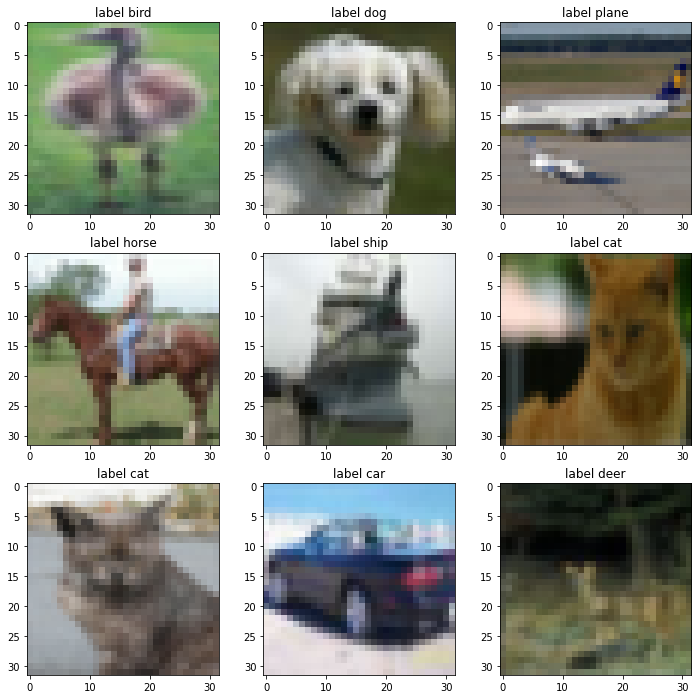

In [5]:
import numpy as np
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size_test,
    shuffle=False,
)

# (Batchsize x Channel x Height x Width)
batch_idx, (images, targets) = next(enumerate(train_loader))

# Label Name
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def CIFAR_plot_visualize():
  fig, ax = plt.subplots(3,3)
  fig.set_size_inches(12,12)

  for i in range(3):
    for j in range(3):
      npImage = np.transpose((torchvision.utils.make_grid(images[i*3+j]/2+0.5)).numpy(), (1,2,0))
      ax[i,j].imshow(npImage)
      ax[i,j].set_title(f'label {classes[targets[i*3+j]]}')
  fig.show()

CIFAR_plot_visualize()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards:


*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [6]:
# You should have your test accuracy printed in the output box

incorrected_img = []

def CIFAR_test(classifier, epoch):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for i, (images, targets) in enumerate(test_loader):
      output = classifier(images)
      test_loss += F.nll_loss(output, targets, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      if pred[i] != targets[i] and len(incorrected_img) < 4:
        incorrected_img.append({"image": images[i], "predicted": classes[pred[i]], "label": classes[targets[i]]})
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

class CifarCNN(nn.Module):
  
  def __init__(self):
    super(CifarCNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, 1)

# Test Accuracy for Convolutional Neural Network on CIFAR-10
classifier = CifarCNN()
cifarcnn_classifier = classifier
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.8)

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3

print("Test for Convolutional Neural Network on CIFAR-10:\n")
for epoch in range(1, max_epoch+1):
  train(classifier, epoch)
  CIFAR_test(classifier, epoch)


Test for Convolutional Neural Network on CIFAR-10:

Epoch 1: [0/50000] Loss: 2.308941602706909
Epoch 1: [6400/50000] Loss: 2.1428382396698
Epoch 1: [12800/50000] Loss: 1.8478877544403076
Epoch 1: [19200/50000] Loss: 1.7834783792495728
Epoch 1: [25600/50000] Loss: 1.5847634077072144
Epoch 1: [32000/50000] Loss: 1.6177501678466797
Epoch 1: [38400/50000] Loss: 1.7041960954666138
Epoch 1: [44800/50000] Loss: 1.499781847000122
Test result on epoch 1: Avg loss is 1.5236200561523439, Accuracy: 44.70000076293945%
Epoch 2: [0/50000] Loss: 1.7022777795791626
Epoch 2: [6400/50000] Loss: 1.4006712436676025
Epoch 2: [12800/50000] Loss: 1.4020601511001587
Epoch 2: [19200/50000] Loss: 1.5540591478347778
Epoch 2: [25600/50000] Loss: 1.4420422315597534
Epoch 2: [32000/50000] Loss: 1.6624797582626343
Epoch 2: [38400/50000] Loss: 1.2684218883514404
Epoch 2: [44800/50000] Loss: 1.4628446102142334
Test result on epoch 2: Avg loss is 1.330558251953125, Accuracy: 52.20000076293945%
Epoch 3: [0/50000] Loss: 1

### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label



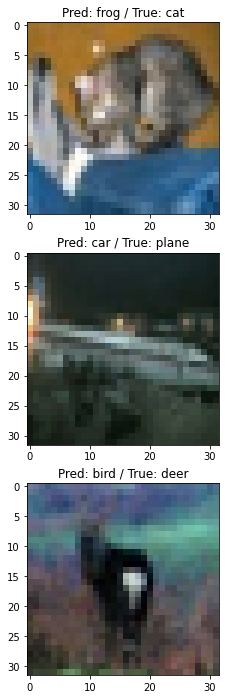

In [7]:
def CIFAR_Incorrected_plot_visualize():
  fig, ax = plt.subplots(3)
  fig.set_size_inches(12,12)

  for i in range(3):
    npImage = np.transpose((torchvision.utils.make_grid(incorrected_img[i]['image']/2+0.5).numpy()), (1,2,0))
    ax[i].imshow(npImage)
    ax[i].set_title(f'Pred: ' + incorrected_img[i]['predicted'] + ' / True: ' + incorrected_img[i]['label'])
  fig.show()

CIFAR_Incorrected_plot_visualize()

Questions (0 points): Are the mis-classified images also misleading to human eyes?

Given quality of picture it could be misleading, but not totally.

## Exercise 3: Transfer Learning (30 points)

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [17]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18_classifier = resnet18.to(device)

### Task2: Create data loaders for CIFAR-10

Then you need to create a dataloader of CIFAR-10. Note that the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width. See [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize).
You will probably want to add this transform appropriately to the `transform` you created in a previous task.


In [18]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size_train,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size_test,
    shuffle=False
)


Files already downloaded and verified
Files already downloaded and verified


### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [34]:
resnet18_optimizer = optim.SGD(resnet18_classifier.parameters(), lr=0.01, momentum=0.8)

def train(classifier, epoch):

  classifier.train() # we need to set the mode for our model

  for batch_idx, (images, targets) in enumerate(train_loader):

    images = images.to(device)
    targets = targets.to(device)
    resnet18_optimizer.zero_grad()
    output = classifier(images)
    loss = loss_fn(output, targets)
    loss.backward()
    resnet18_optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 10 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

def test(classifier, epoch):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(device)
      targets = targets.to(device)
      output = classifier(images)
      test_loss += F.nll_loss(output, targets, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')


In [20]:
# Test Accuracy for ResNet18 on CIFAR-10

test_losses = []
test_counter = []
max_epoch = 2

print("Test for ResNet18 on CIFAR-10:\n")
for epoch in range(1, max_epoch+1):
  test(resnet18_classifier, epoch)

Test for ResNet18 on CIFAR-10:

Test result on epoch 1: Avg loss is 0.7733426818847656, Accuracy: 0.029999999329447746%
Test result on epoch 2: Avg loss is 0.7733426818847656, Accuracy: 0.029999999329447746%


### Task 4: Update model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data. 

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You should print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [38]:
loss_fn = nn.CrossEntropyLoss()
for param in resnet18_classifier.parameters():
    param.requires_grad = True

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 1

print("Train and test for ResNet18 on CIFAR-10:\n")
for epoch in range(1, max_epoch+1):
  train(resnet18_classifier, epoch)
  test(resnet18_classifier, epoch)

Train and test for ResNet18 on CIFAR-10:

Epoch 1: [0/50000] Loss: 0.22005407512187958
Epoch 1: [6400/50000] Loss: 0.28739964962005615
Epoch 1: [12800/50000] Loss: 0.2041682004928589
Epoch 1: [19200/50000] Loss: 0.2604939043521881
Epoch 1: [25600/50000] Loss: 0.18055635690689087
Epoch 1: [32000/50000] Loss: 0.2347770482301712
Epoch 1: [38400/50000] Loss: 0.16100767254829407
Epoch 1: [44800/50000] Loss: 0.14175215363502502
Test result on epoch 1: Avg loss is -22.4392359375, Accuracy: 91.75%
